In [0]:
import pandas as pd
import numpy as np
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from random import seed
seed(22)
# define pipeline to standardize the inputs and one hot encode the categorical variables
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])
# define numerical and categorical attributes for pipeline to distinguish between
num_attribs = ['own', 'random', 'lb', 'db', 'dl', 'yds2go', 'distfromside', 'definbox', 
               'timetohand', 'timeinhalf', 'netscore', 'sp', 'acc']
cat_attribs = ['down', 'rundir', 'offt', 'deft', 'precipitation', 'secondhalf']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
num_attribs2 = ['yards']
cat_attribs2 = []

full_pipeline2 = ColumnTransformer([
        ("num", num_pipeline, num_attribs2),
        ("cat", OneHotEncoder(), cat_attribs2),
    ])
sd22 = pd.read_csv("own_yards_comp.csv")

# randomly seperate into testing and training sets
msk = np.random.rand(len(sd22)) < 0.8
train = sd22[msk]
test = sd22[~msk]

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
y_train = pd.DataFrame({"yards":y_train})
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
y_test = pd.DataFrame({"yards":y_test})

x_train_prepared = full_pipeline.fit_transform(x_train)
y_train_prepared = full_pipeline2.fit_transform(y_train)
x_test_prepared = full_pipeline.transform(x_test)
y_test_prepared = full_pipeline2.transform(y_test)

In [0]:
x_train.iloc[0]

own                -0.350881
random                    24
acc                     3.35
db                         6
definbox                   6
deft                      KC
distfromside           22.77
dl                         2
down                       3
lb                         3
netscore                   0
offt                      NE
precipitation          False
rundir           left_middle
secondhalf             False
sp                      3.63
timeinhalf              1754
timetohand                 1
yds2go                     2
Name: 0, dtype: object

In [0]:
print(x_train_prepared[0,:])

  (0, 0)	-0.35350891003246515
  (0, 1)	0.4295739550100455
  (0, 2)	0.055506126916990556
  (0, 3)	2.5726642423766393
  (0, 4)	-2.0853413077206673
  (0, 5)	-1.894767036213273
  (0, 6)	-0.5020080145988978
  (0, 7)	-1.062677018090178
  (0, 8)	0.009576327700802285
  (0, 9)	1.4359606527062796
  (0, 10)	0.009000826282164873
  (0, 11)	-0.5722306101184105
  (0, 12)	0.7900371245892087
  (0, 15)	1.0
  (0, 17)	1.0
  (0, 42)	1.0
  (0, 69)	1.0
  (0, 86)	1.0
  (0, 88)	1.0


In [0]:
from sklearn.model_selection import RandomizedSearchCV
# define hyperparameters to be tuned with cross validation
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 60, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
from sklearn.ensemble import RandomForestRegressor
# initialize random forest regressor
rf = RandomForestRegressor()
# conduct randomized search through cross validation to determine optimal hyperparameters
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = 3, verbose=2, 
                               random_state=22)
# fit the random search model
rf_random.fit(x_train_prepared, y_train_prepared.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False, total=  12.2s
[CV] n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False, total=  13.0s
[CV] n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False 
[CV]  n_estimators=33, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=21, bootstrap=False, total=  12.7s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   3.5s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   3.8s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [0]:
print(rf_random.best_params_)

{'n_estimators': 46, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True}


In [0]:
from sklearn.metrics import mean_squared_error

clf=RandomForestRegressor(n_estimators=46, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=12,
                          random_state=42, bootstrap=True)

# #Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train_prepared,y_train_prepared)

y_pred = clf.predict(x_test_prepared)
# Calculate the absolute errors
errors = mean_squared_error(y_pred, y_test_prepared)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Mean Absolute Error: 0.83


In [0]:
impdf = pd.DataFrame(clf.feature_importances_,
                   columns=['importance']).sort_values('importance', ascending=False)

impdf["Rank"] = 89 - impdf["importance"].rank() 
impdf.head(10)

,importance,Rank
12,0.204337,-1.0
11,0.110607,0.0
9,0.076879,1.0
1,0.065279,2.0
6,0.062407,3.0
0,0.061705,4.0
10,0.036048,5.0
7,0.025423,6.0
5,0.019336,7.0
2,0.019329,8.0


In [0]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None


In [0]:
if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=22)
    xgb_reg.fit(x_train_prepared, y_train_prepared)
    y_pred = xgb_reg.predict(x_test_prepared)
    val_error = mean_squared_error(y_test_prepared, y_pred) 
    print("Validation MSE:", val_error)       

[22:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.8191575728159012


In [0]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
from matplotlib.pyplot import figure
plt.figure(figsize=(24,12))
imp = xgb_reg.get_booster().get_score(importance_type='gain')
print(imp)
k = []
im = []
for key in list(imp.keys()):
  k.append(key)
  im.append(imp[key])
impdf = pd.DataFrame({"features":k, "importances":im})
impdf = impdf.sort_values('importances', ascending=False)
impdf["Rank"] = 64 - impdf["importances"].rank() 
impdf.head(60)
# plot
# plt.bar(range(len(xgb_reg.feature_importances_)), xgb_reg.feature_importances_)

# plot_importance(xgb_reg)
# plt.tick_params(labelsize=8)
# plt.show()

{'f12': 22.414775039018863, 'f11': 10.133500603189653, 'f3': 12.893796586, 'f18': 8.993636372666666, 'f37': 7.574265480000002, 'f33': 12.2945634225, 'f0': 8.816148270755557, 'f66': 5.558135575555554, 'f6': 5.918834288382353, 'f43': 9.138976342500001, 'f73': 7.3495310966666665, 'f19': 6.8690632721428555, 'f5': 4.80674344, 'f20': 6.72468119235294, 'f7': 6.821091307142857, 'f15': 10.694118181666667, 'f9': 7.072288260487807, 'f81': 12.89955592, 'f46': 16.312908424999996, 'f63': 10.03717048, 'f1': 5.77045286775, 'f86': 9.22489478375, 'f30': 3.3904194480000003, 'f10': 17.025059034444443, 'f79': 11.6192026, 'f38': 6.145562655, 'f52': 4.49623227, 'f57': 3.39571095, 'f26': 4.2793800675, 'f82': 1.72801304, 'f8': 3.6422658, 'f83': 4.388384866, 'f41': 6.88614416, 'f72': 8.97004986, 'f49': 2.6417584425, 'f22': 2.6725709450000004, 'f59': 2.6224670974999995, 'f47': 4.168931785, 'f48': 1.8568943733333334, 'f64': 8.34535837, 'f42': 2.2680084099999998, 'f78': 4.37280321, 'f67': 4.34716797, 'f61': 7.8672

,features,importances,Rank
51,f23,66.639229,5.0
0,f12,22.414775,6.0
57,f58,19.246403,7.0
23,f10,17.025059,8.0
18,f46,16.312908,9.0
17,f81,12.899556,10.0
2,f3,12.893797,11.0
5,f33,12.294563,12.0
24,f79,11.619203,13.0
15,f15,10.694118,14.0


<Figure size 1728x864 with 0 Axes>

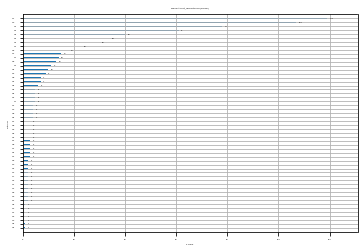

In [0]:
xgboost.plot_importance(xgb_reg)
plt.title("xgboost.plot_importance(model)")
plt.show()